In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import io
#from google.colab import files
#from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split
from os import listdir, remove, mkdir, rename, walk
from distutils.dir_util import copy_tree
from shutil import rmtree
import random as random
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np

# https://stackoverflow.com/questions/49186905/loading-images-in-google-colab
# https://www.youtube.com/watch?v=chQNuV9B-Rw
# https://heartbeat.fritz.ai/getting-started-with-google-colab-notebooks-117e2bb0c220

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = [48, 48]
EPOCHS = 10
SEED=1973

# Dividir conjuntos

- https://keras.io/api/preprocessing/image/
- https://stackoverflow.com/questions/63104923/how-to-convert-my-dataset-to-the-format-returned-by-tfds-load-using-tf-keras-pre

```python
tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)
```

In [4]:
# ME FALTA TEST >> MÉTODO 2 >> PRIMERO DIVIDO TRAIN EN TRAIN_DS Y VAL_DS (35%):

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "totrain/totrain", labels="inferred",
    validation_split=0.35, label_mode="int", color_mode = "grayscale",
    subset="training", image_size=IMAGE_SIZE,
    seed=SEED, batch_size=16)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "totrain/totrain", labels="inferred",
    validation_split=0.35, label_mode="int", color_mode = "grayscale", 
    subset="validation", image_size=IMAGE_SIZE,
    seed=SEED, batch_size=16)

Found 6176 files belonging to 2 classes.
Using 4015 files for training.
Found 6176 files belonging to 2 classes.
Using 2161 files for validation.


In [5]:
train_ds

<BatchDataset shapes: ((None, 48, 48, 1), (None,)), types: (tf.float32, tf.int32)>

In [6]:
train_ds.class_names

['happy', 'sadness']

## Conjunto de test

In [7]:
'''
# ME FALTA TEST >> MÉTODO 2+ >> AHORA COJO UN 20% DE VAL_DS Y LO CONVIERTO EN MI TEST_DS.

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
'''

'\n# ME FALTA TEST >> MÉTODO 2+ >> AHORA COJO UN 20% DE VAL_DS Y LO CONVIERTO EN MI TEST_DS.\n\nval_batches = tf.data.experimental.cardinality(val_ds)\ntest_ds = val_ds.take(val_batches // 5)\nval_ds = val_ds.skip(val_batches // 5)\n'

# Observo y preparo los datos

In [8]:
train_ds.class_names

['happy', 'sadness']

In [9]:
NUM_CLASSES = len(train_ds.class_names)

In [10]:
NUM_CLASSES

2

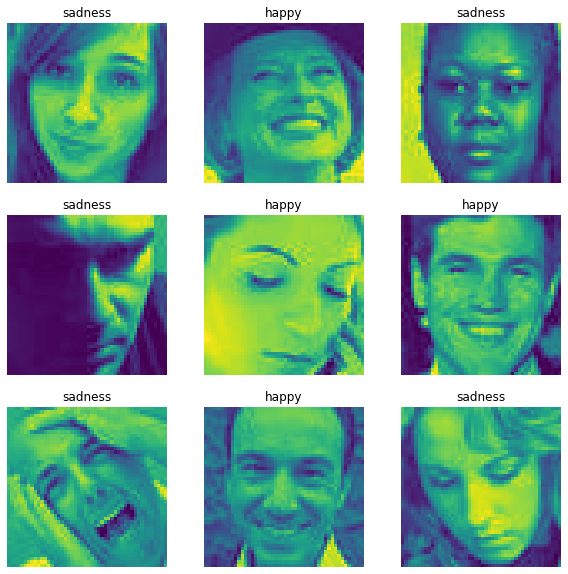

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).reshape(48,48))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [12]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds.class_names

In [13]:
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preparo el modelo con funciones por bloques de tipos de neuronas

In [14]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [15]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(), #capa de normalización ya incluida en el modelo
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES,activation="softmax")
    ])
    
    return model

In [17]:
model = build_model()

METRICS = [tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)]

model.compile(
    optimizer='rmsprop',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [18]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("kaggle_rmsprop.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

In [34]:
train_ds.take(1)

<TakeDataset shapes: ((None, 48, 48, 1), (None, 2)), types: (tf.float32, tf.float32)>

El shape de cada foto es: (None, 48, 48, 1), 4 dimensiones, por eso al predecir el input tendrá que tener shape (1, 48, 48, 1)

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/10
251/251 [==============================] - 21s 85ms/step - loss: 0.7680 - auc: 0.5097 - binary_accuracy: 0.5073 - val_loss: 2.6045 - val_auc: 0.4412 - val_binary_accuracy: 0.4604
Epoch 2/10
251/251 [==============================] - 22s 88ms/step - loss: 0.7111 - auc: 0.5342 - binary_accuracy: 0.5280 - val_loss: 0.7800 - val_auc: 0.5043 - val_binary_accuracy: 0.4882
Epoch 3/10
251/251 [==============================] - 24s 94ms/step - loss: 0.6996 - auc: 0.5373 - binary_accuracy: 0.5283 - val_loss: 0.6874 - val_auc: 0.5814 - val_binary_accuracy: 0.5733
Epoch 4/10
251/251 [==============================] - 24s 94ms/step - loss: 0.6910 - auc: 0.5624 - binary_accuracy: 0.5499 - val_loss: 0.6827 - val_auc: 0.5670 - val_binary_accuracy: 0.5275
Epoch 5/10
251/251 [==============================] - 25s 98ms/step - loss: 0.6849 - auc: 0.5829 - binary_accuracy: 0.5624 - val_loss: 0.7040 - val_auc: 0.5662 - val_binary_accuracy: 0.5507
Epoch 6/10
251/251 [==============================

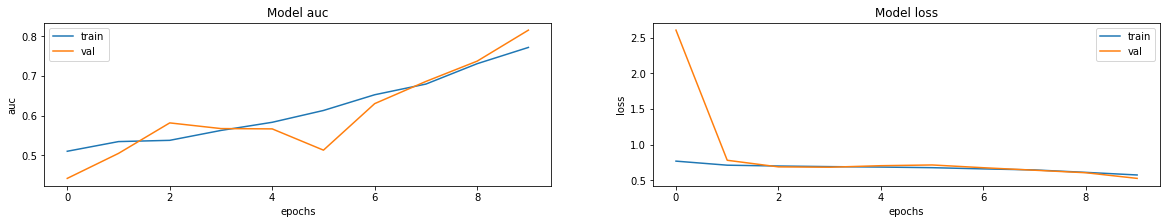

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Predecir con to_pred

In [26]:
prediction = pd.read_csv("test_set.csv")

In [27]:
prediction

,id_img,path
0,18341,to_pred/18341.jpg
1,13176,to_pred/13176.jpg
2,23945,to_pred/23945.jpg
3,15968,to_pred/15968.jpg
4,18382,to_pred/18382.jpg
...,...,...
4112,8966,to_pred/08966.jpg
4113,12111,to_pred/12111.jpg
4114,16629,to_pred/16629.jpg
4115,24322,to_pred/24322.jpg


In [35]:
#tarda un ratito
prediction['prediction'] = prediction['path'].apply(lambda x: model.predict(cv2.cvtColor(cv2.imread("to_pred/"+x), cv2.COLOR_BGR2GRAY).reshape(1,48,48,1)))

```python
['happy', 'sadness']
```

In [43]:
prediction['solution'] = prediction['prediction'].apply(lambda x: 'happy' if x[0][0] > x[0][1] else 'sadness')

In [44]:
prediction

,id_img,path,prediction,solution
0,18341,to_pred/18341.jpg,"[[0.5845865, 0.4154135]]",happy
1,13176,to_pred/13176.jpg,"[[0.9396081, 0.06039193]]",happy
2,23945,to_pred/23945.jpg,"[[0.4690208, 0.5309792]]",sadness
3,15968,to_pred/15968.jpg,"[[0.94084924, 0.05915078]]",happy
4,18382,to_pred/18382.jpg,"[[0.9378692, 0.06213079]]",happy
...,...,...,...,...
4112,8966,to_pred/08966.jpg,"[[0.8410154, 0.15898463]]",happy
4113,12111,to_pred/12111.jpg,"[[0.22531477, 0.77468526]]",sadness
4114,16629,to_pred/16629.jpg,"[[0.50883645, 0.49116355]]",happy
4115,24322,to_pred/24322.jpg,"[[0.6547304, 0.34526962]]",happy


In [45]:
#prediction.to_csv('predicti.csv')

In [51]:
prediction['path'].tolist()[:10]

['to_pred/18341.jpg',
 'to_pred/13176.jpg',
 'to_pred/23945.jpg',
 'to_pred/15968.jpg',
 'to_pred/18382.jpg',
 'to_pred/08256.jpg',
 'to_pred/21635.jpg',
 'to_pred/02418.jpg',
 'to_pred/04515.jpg',
 'to_pred/27618.jpg']

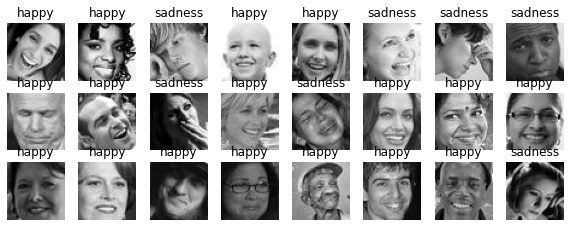

In [59]:
plt.figure(figsize=(10, 10))
for i, e in enumerate(prediction['path'].tolist()[:24]):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(cv2.imread('to_pred/' + e))
    plt.title(prediction['solution'][i])
    plt.axis("off")

Cambiar el shape de la foto a (1,48,48,1) 

In [61]:
submission = prediction[['id_img', 'solution']]
#submission.to_csv('to_submit.csv')

# Solucion correcta 

In [62]:
validando = pd.read_csv('ground_truth.csv')

In [63]:
validando

,id_img,label
0,18341,happy
1,13176,happy
2,23945,sadness
3,15968,happy
4,18382,happy
...,...,...
4112,8966,happy
4113,12111,happy
4114,16629,happy
4115,24322,happy


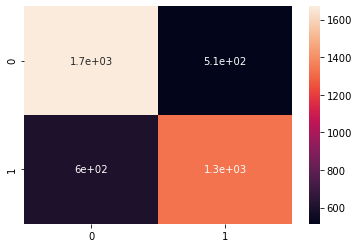

In [74]:
confusion = confusion_matrix(validando['label'], prediction['solution'])
sns.heatmap(confusion, annot=True)